In [2]:
import os
import yaml
import zipfile
import numpy as np
import pickle
from six.moves import urllib
import matplotlib.pyplot as plt
import sys
sys.path.append('lib')

from prediction.tf_classifier import TFClassifier, HOP_LENGTH

import os, argparse
import tensorflow as tf

In [3]:
# where to download the pretrained models from
models_dl_path = 'https://www.dropbox.com/s/50ketdmtn6bd1oa/tf_models.zip?dl=1'

print("-> Downloading and unzipping pre-trained model...")

if not os.path.exists('tf_models/biotic/network_opts.yaml'):

    if not os.path.isdir("tf_models"):
        os.makedirs("tf_models")

    if not os.path.exists('tf_models/models.zip'):
        urllib.request.urlretrieve(models_dl_path, "tf_models/models.zip")
        # wget.download(models_dl_path, 'models')

    with zipfile.ZipFile('tf_models/models.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

print("-> ...Done")

-> Downloading and unzipping pre-trained model...
-> ...Done


In [6]:
print("->  Making predictions for biotic and anthropogenic separately")

preds = {}

models = {}

for classifier_type in ['biotic', 'anthrop']:

    with open('tf_models/%s/network_opts.yaml' % classifier_type) as f:
        options = yaml.load(f)

    model_path = 'tf_models/%s/weights_99.pkl-1' % classifier_type

    predictor = TFClassifier(options, model_path)
    models[classifier_type] = predictor
    preds[classifier_type] = predictor.classify("demo/NW23SH-13548_20150811_16300021.wav")

print("-> ...Done")

->  Making predictions for biotic and anthropogenic separately
Loading from tf_models/biotic/weights_99.pkl-1
INFO:tensorflow:Restoring parameters from tf_models/biotic/weights_99.pkl-1


C:\Users\leoco\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:10: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  # Remove the CWD from sys.path while we load stuff.


Took 0.374s to classify
Loading from tf_models/anthrop/weights_99.pkl-1
INFO:tensorflow:Restoring parameters from tf_models/anthrop/weights_99.pkl-1
Took 0.376s to classify
-> ...Done


In [7]:
print("-> Saving predictions to disk")

with open('demo/predictions.pkl', 'wb') as f:
    pickle.dump(preds, f, -1)

print("-> ...Done")

-> Saving predictions to disk
-> ...Done


-> Plotting predictions
60.00036281179138
60.00036281179138
-> ...Done


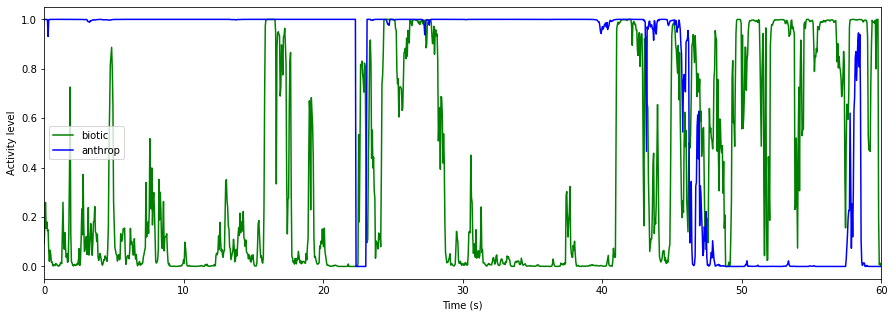

In [6]:
print("-> Plotting predictions")

plt.figure(figsize=(15, 5))
cols = {'anthrop': 'b', 'biotic': 'g'}

for key, val in preds.items():
    len_in_s = val.shape[0] * HOP_LENGTH / predictor.sample_rate
    print(len_in_s)

    x = np.linspace(0, len_in_s, val.shape[0])
    plt.plot(x, val, cols[key], label=key)

    plt.xlabel('Time (s)')
    plt.ylabel('Activity level')

# plt.ylim(0, 1.2)
plt.xlim(0, 60)
plt.legend()
plt.savefig('demo/predictions.pdf')

print("-> ...Done")


In [8]:
allnodes = [n.name for n in tf.get_default_graph().as_graph_def().node]

In [10]:
filtered = [n for n in allnodes if "input" in n.lower()]

In [11]:
filtered

['input', 'save/filename/input']

In [18]:
# Converting non-quantized model

graph_def_file = "tf_models/anthrop/frozen_1.pb"
input_arrays = ['input']
output_arrays = ['Softmax']

converter = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

3049732

In [21]:
# Converting quantized model
converter2 = tf.lite.TFLiteConverter.from_frozen_graph(graph_def_file, input_arrays, output_arrays)
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter2.convert()
open("tf_models/anthrop/converted_model_quant.tflite", "wb").write(tflite_quant_model)

767256